* Check if 10.5 m is deep enough to trap the plume according to the plume threshold.

In [23]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools,psu_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import DetermineEdgePlume as DEP
import R_mixStuff as RS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
sites = {'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
        'NS':{'lat':49.17,'lon':-123.30,'j': 60,'i':61},
        'WS':{'lat':49.11,'lon':-123.40,'j': 53,'i':38}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [4]:
## load grid_T model results
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')

In [5]:
def Extract_Salinity(grid_T,stn,tst,ted,dep):
    """
    Extract salinity at a single depth at a station, in order to plot the histogram
    """
    S = grid_T.variables['vosaline']
    S_Extract= S[tst:ted+1,dep,sites[stn]['j'],sites[stn]['i']]

    return S_Extract

In [6]:
S_jan = Extract_Salinity(janall_T,'NS',0,743,10)
S_oct = Extract_Salinity(octall_T,'NS',0,743,10)
S_may = Extract_Salinity(mayall_T,'NS',0,743,10)

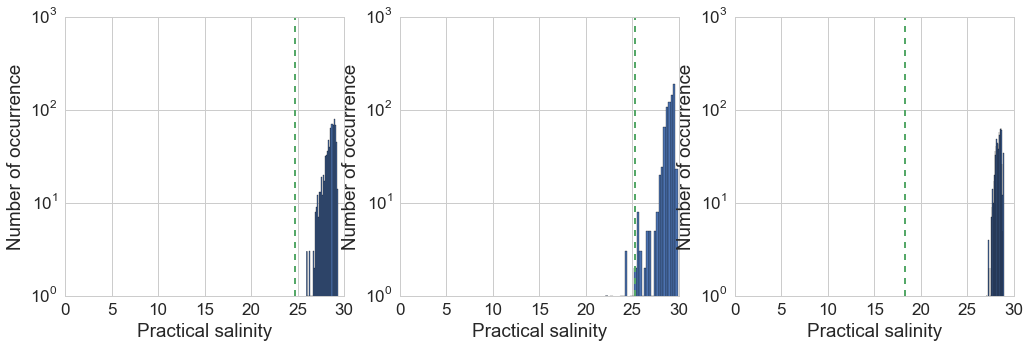

In [7]:
fig,axs = plt.subplots(1,3,figsize = (17,5))
ax = axs[0]
ax.hist(S_jan,bins = 30)
ax.plot([24.7,24.7],[1e0,1e3],'--') ## plume threshold based on criteria
ax = axs[1]
ax.hist(S_oct,bins = 30)
ax.plot([25.3,25.3],[1e0,1e3],'--')
ax = axs[2]
ax.hist(S_may,bins = 30)
ax.plot([18.3,18.3],[1e0,1e3],'--')
for ax in axs.flatten():
    ax.set_ylim([1e0,1e3])
    ax.set_yscale('log')
    ax.set_xlim([0,30])
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

In [8]:
14/744

0.01881720430107527

* Check if 30 is good enough to be the reference SoG salinity

In [9]:
def Northern_Salinity(grid_T,tst,ted,dep):
    """
    Calculate the spatial mean salinity at the selected depth of the 2.5*2.5 km in the northern of my subdomain 
    """
    S = grid_T.variables['vosaline']
    S_dep = np.ma.masked_values(S[tst:ted+1,dep,-5:,0:5],0)
    S_ref = np.nanmean(S_dep,axis = 2) ## spatial average of northern region    
    S_ref = np.nanmean(S_ref,axis = 1)
    return S_ref

In [15]:
S_refOct = Northern_Salinity(octall_T,0,743,0)
S_refJan = Northern_Salinity(janall_T,0,743,0)
S_refMay = Northern_Salinity(mayall_T,0,743,0)

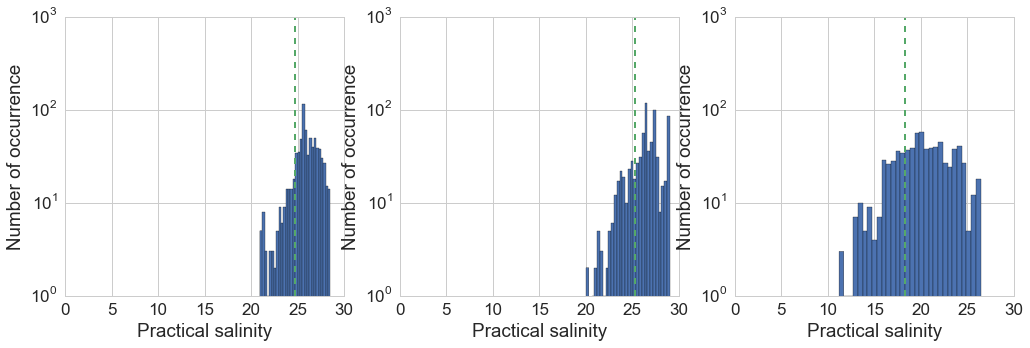

In [16]:
fig,axs = plt.subplots(1,3,figsize = (17,5))
ax = axs[0]
ax.hist(S_refJan,bins = 30)
ax.plot([24.7,24.7],[1e0,1e3],'--') ## plume threshold based on criteria
ax = axs[1]
ax.hist(S_refOct,bins = 30)
ax.plot([25.3,25.3],[1e0,1e3],'--')
ax = axs[2]
ax.hist(S_refMay,bins = 30)
ax.plot([18.3,18.3],[1e0,1e3],'--')
for ax in axs.flatten():
    ax.set_ylim([1e0,1e3])
    ax.set_yscale('log')
    ax.set_xlim([0,30])
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

In [34]:
def Northern_SalinityOverDepth(grid_T,tst,ted,dep):
    """
    Calculate the spatial mean salinity of multiple depths of the 2.5*2.5 km in the northern of my subdomain 
    """
    S = grid_T.variables['vosaline']
    Depth = grid_T.variables['deptht']
    S_dep = np.ma.masked_values(S[tst:ted+1,0:dep,-5:,0:5],0)
    S_ref = np.nanmean(S_dep,axis = 2) ## spatial average of northern region  
    S_ref = np.nanmean(S_ref,axis = 2)
    
    T = grid_T.variables['votemper']
    T_dep = np.ma.masked_values(T[tst:ted+1,0:dep,-5:,0:5],0)
    T_ref = np.nanmean(T_dep,axis = 2) ## spatial average of northern region  
    T_ref = np.nanmean(T_ref,axis = 2)
    return S_ref, Depth, T_ref

In [35]:
dep = 30
S_refOctDep,Depth,T_refOctDep = Northern_SalinityOverDepth(octall_T,0,743,dep)
S_refJanDep,Depth,T_refJanDep = Northern_SalinityOverDepth(janall_T,0,743,dep)
S_refMayDep,Depth,T_refMayDep = Northern_SalinityOverDepth(mayall_T,0,743,dep)

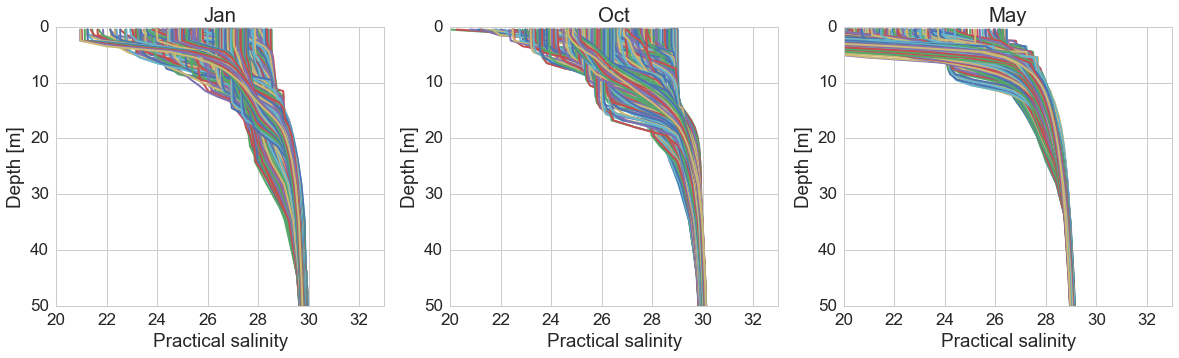

In [21]:
dep = 30
fig,axs = plt.subplots(1,3,figsize = (20,5))
ax = axs[0]
for i in range(743):
    ax.plot(S_refJanDep[i,0:dep],Depth[0:dep])
ax = axs[1]
for i in range(743):
    ax.plot(S_refOctDep[i,0:dep],Depth[0:dep])
ax = axs[2]
for i in range(743):
    ax.plot(S_refMayDep[i,0:dep],Depth[0:dep])
for ax, title in zip(axs.flatten(), ['Jan','Oct','May']):
    ax.set_ylim([50,0])
    ax.set_xlim([20,33])
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Depth [m]')
    ax.set_title(title)
plt.show()

In [22]:
T = {}
S = {}
for mon, Tgrid in zip(['jan','oct','may'],[janall_T,octall_T,mayall_T]):
    S[mon] = Tgrid.variables['vosaline']
    T[mon] = Tgrid.variables['votemper']

In [27]:
Den = {}
for mon in ['jan','oct','may']:
    Den[mon] = psu_tools.calculate_density(T[mon][:,:,sites['NS']['j'],sites['NS']['i']],S[mon][:,:,sites['NS']['j'], sites['NS']['i']])

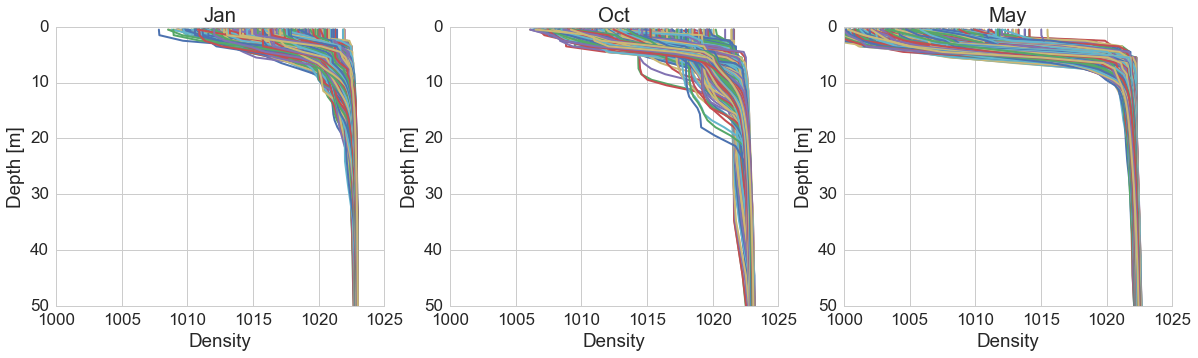

In [32]:
fig,axs = plt.subplots(1,3,figsize = (20,5))
ax = axs[0]
for i in range(743):
    ax.plot(Den['jan'][i,0:dep],Depth[0:dep])
ax = axs[1]
for i in range(743):
    ax.plot(Den['oct'][i,0:dep],Depth[0:dep])
ax = axs[2]
for i in range(743):
    ax.plot(Den['may'][i,0:dep],Depth[0:dep])
    
for ax, title in zip(axs.flatten(), ['Jan','Oct','May']):
    ax.set_ylim([50,0])
    ax.set_xlim([1000,1025])
    ax.set_xlabel('Density')
    ax.set_ylabel('Depth [m]')
    ax.set_title(title)
plt.show()

In [39]:
Density_jan = psu_tools.calculate_density(T_refJanDep,S_refJanDep)
Density_oct = psu_tools.calculate_density(T_refOctDep,S_refOctDep)
Density_may = psu_tools.calculate_density(T_refMayDep,S_refMayDep)

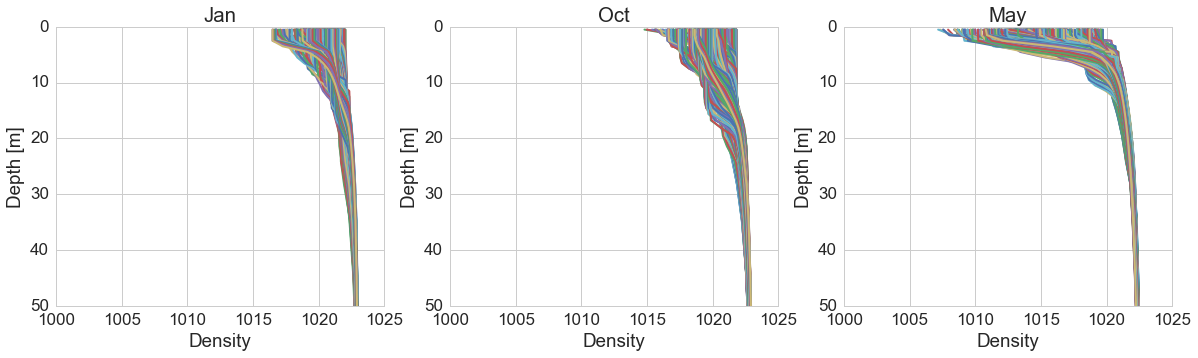

In [40]:
fig,axs = plt.subplots(1,3,figsize = (20,5))
ax = axs[0]
for i in range(743):
    ax.plot(Density_jan[i,0:dep],Depth[0:dep])
ax = axs[1]
for i in range(743):
    ax.plot(Density_oct[i,0:dep],Depth[0:dep])
ax = axs[2]
for i in range(743):
    ax.plot(Density_may[i,0:dep],Depth[0:dep])
    
for ax, title in zip(axs.flatten(), ['Jan','Oct','May']):
    ax.set_ylim([50,0])
    ax.set_xlim([1000,1025])
    ax.set_xlabel('Density')
    ax.set_ylabel('Depth [m]')
    ax.set_title(title)
plt.show()